# EXAMEN FINAL 

## Enunciado



Cada día es más frecuente la introducción de la ciencia de datos en el ámbito del derecho y la justicia. Un ejemplo bien conocido de ello es el sistema COMPAS (Correctional offender management profiling for alternative sanctions) que se usa en varios estados de los Estados Unidos para hacer una evaluación del riesgo de reincidencia de las personas detenidas. Una breve descripción del sistema puede verse en la página https://en.wikipedia.org/wiki/COMPAS_(software).

En este caso, proporciona un conjunto de datos en bruto con información de las evaluaciones (fichero compas-scores.csv) y la historia legal de unos 11.000 casos en los años 2013 y 2014 (se trata de uno de los ficheros originales utilizados en un análisis independiente del sistema COMPAS llevado a cabo por ProPublica, disponible en internet). Aunque el conjunto de datos contiene información adicional, para resolver las cuestiones planteadas en este caso son necesarios (aparte de algunos campos cuyo nombre es autoexplicativo) los siguientes campos:


-       “compas_screening_date”>: se refiere a la fecha en la que se realizó la evaluación

-      “decile_score”: es un número, de 1 a 10 que indica el riesgo de reincidencia en general (a mayor riesgo, mayor número).

-      “v_decile_score”: es un número de 1 a 10, potencialmente distinto del anterior, que indica el riesgo de reincidencia en delitos violentos. Al hacer la evaluación de un caso en COMPAS, se generan las dos puntuaciones (entre otras cosas).

-       “is_recid”: indicación de si la persona es reincidente (en el tiempo en que se recogen datos: no hay información de si la persona es reincidente más allá de ciertas fechas, y es importante tener esto en cuenta para asegurarse de hacer comparaciones homogéneas).

-       “r_offense_date”: fecha en la que se cometió el delito por el que se considera reincidente a la persona.

-       “is_violent_recid”: indicación de si la persona es reincidente en un delito con violencia (las mismas consideraciones sobre fechas que para “is_recid” aplican aquí)".

-       “vr_offense_date”: fecha en la que se cometió el delito violento que da lugar a la consideración de reincidente.

## Se pide

1. Cargar los datos y realizar un análisis exploratorio y una evaluación de la calidad de los datos necesarios para el resto del caso. Específicamente, evaluar la integridad, validez y actualidad de los datos y proponer estrategias de mitigación de los posibles problemas encontrados.

2. ¿Son los campos “is_recid” e “is_violent_recid” en este conjunto de datos adecuados para evaluar la precisión de las estimaciones de riesgo generadas por el sistema COMPAS? Si no es así, definir y calcular una feature que sí lo sea.


3. El umbral para establecer medidas preventivas de la reincidencia es de 7 en adelante. Dado este umbral, generar una tabla de contingencia, explicando qué caso se considera como “positivo” (y, por lo tanto, cuáles son los errores de tipo I y los errores de tipo II).


4. El sistema asigna, de media, evaluaciones de riesgo más altas a los hombres que a las mujeres, y a las personas de raza afroamericana que a las de raza caucásica. Sin embargo, también las tasas de reincidencia son más altas para esos colectivos, aunque no está claro que la asignación de riesgo sea “justa” o no. Mostrar estas diferencias mediante representaciones gráficas y utilizarlas para analizar si la asignación de evaluaciones es justa o no.
  

5. ¿Para qué tipo de riesgos, el de delitos generales o el de delitos violentos, tiene el sistema más capacidad predictiva?

In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets
import altair as alt

import os.path
import urllib.request

In [2]:
def cant_nulos (df):
    print("*CANTIDAD de datos nulos por columna en el dataframe")
    print(df.isnull().sum())
    print("----------------------------------")
    print("*PORCENTAJE de datos nulos por columna en el dataframe")
    print(df.isnull().sum()/len(df)*100)

In [3]:
def describe_columna(df, col):
    print(f'Columna: {col}  -  Tipo de datos: {df[col].dtype}')
    print(f'Número de valores nulos: {df[col].isnull().sum()}  -  Número de valores distintos: {df[col].nunique()}')
    print('Valores más frecuentes:')
    for i, v in df[col].value_counts().iloc[:200].items() :
        print(i, '\t', v)

In [4]:
def val_uniques (df):
    headers = df.keys().tolist()
    print("LISTA DE VALORES ÚNICOS")
    print("==================================")
    for col in headers:
        print(col)
        print("----------------------------------")
        uniques = df[col].unique().tolist()
        for val in uniques:
            print(val)
        print("----------------------------------")

## 1. Cargar los datos y realizar un análisis exploratorio y una evaluación de la calidad de los datos necesarios para el resto del caso. Específicamente, evaluar la integridad, validez y actualidad de los datos y proponer estrategias de mitigación de los posibles problemas encontrados.

### 1.1 Cargamos los datos

In [5]:
# Vamos a comprobar el directorio en el que estamos trabajando

cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in 'C:\\Users\\carle\\Master Data Sciene and Business Analytics\\Ciencia de datos\\UD8_Examen final': ['.ipynb_checkpoints', 'compas-scores.csv', 'compas-scores.parquet', 'ExamenFinal_CG-NM.ipynb']


In [6]:
# Realizamos una breve lectura del csv de las primeras 5 líneas, para adquirir info como el tipo de separador del archivo

with open("compas-scores.csv", encoding = 'latin1') as f:
    for _ in range(5) : print(f.readline())

id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,num_r_cases,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,is_violent_recid,num_vr_cases,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,type_of_assessment,decile_score,score_text,screening_date

1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,,1,F,Aggravated Assault w/Firearm,0,,,O,,,,,,0,,,,,,Risk of Violence,1,Low,2013-08-14,Risk of Recidivism,1,Low,2013-08-14

2,michael ryan,michael,ryan,2014-12-31,Male,1985-02-06,31,25 - 45,Caucasian,0,5,0,0,0,,,,,,,,O,,-1,

In [7]:
# Creamos un DataFrame con los datos del csv

df_compas = pd.read_csv("compas-scores.csv")
df_compas.shape

df_compas.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,vr_offense_date,vr_charge_desc,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,type_of_assessment,decile_score.1,score_text,screening_date
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,NaN,NaN,Risk of Violence,1,Low,2013-08-14,Risk of Recidivism,1,Low,2013-08-14
1,2,michael ryan,michael,ryan,2014-12-31,Male,1985-02-06,31,25 - 45,Caucasian,...,NaN,NaN,Risk of Violence,2,Low,2014-12-31,Risk of Recidivism,5,Medium,2014-12-31
2,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,2013-07-05,Felony Battery (Dom Strang),Risk of Violence,1,Low,2013-01-27,Risk of Recidivism,3,Low,2013-01-27
3,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,NaN,NaN,Risk of Violence,3,Low,2013-04-14,Risk of Recidivism,4,Low,2013-04-14
4,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,NaN,NaN,Risk of Violence,6,Medium,2013-01-13,Risk of Recidivism,8,High,2013-01-13


In [8]:
# Para ver todas las variables de df_compas

df_compas.iloc[:3,:].to_dict()

{'id': {0: 1, 1: 2, 2: 3},
 'name': {0: 'miguel hernandez', 1: 'michael ryan', 2: 'kevon dixon'},
 'first': {0: 'miguel', 1: 'michael', 2: 'kevon'},
 'last': {0: 'hernandez', 1: 'ryan', 2: 'dixon'},
 'compas_screening_date': {0: '2013-08-14', 1: '2014-12-31', 2: '2013-01-27'},
 'sex': {0: 'Male', 1: 'Male', 2: 'Male'},
 'dob': {0: '1947-04-18', 1: '1985-02-06', 2: '1982-01-22'},
 'age': {0: 69, 1: 31, 2: 34},
 'age_cat': {0: 'Greater than 45', 1: '25 - 45', 2: '25 - 45'},
 'race': {0: 'Other', 1: 'Caucasian', 2: 'African-American'},
 'juv_fel_count': {0: 0, 1: 0, 2: 0},
 'decile_score': {0: 1, 1: 5, 2: 3},
 'juv_misd_count': {0: 0, 1: 0, 2: 0},
 'juv_other_count': {0: 0, 1: 0, 2: 0},
 'priors_count': {0: 0, 1: 0, 2: 0},
 'days_b_screening_arrest': {0: -1.0, 1: nan, 2: -1.0},
 'c_jail_in': {0: '2013-08-13 06:03:42', 1: nan, 2: '2013-01-26 03:45:27'},
 'c_jail_out': {0: '2013-08-14 05:41:20', 1: nan, 2: '2013-02-05 05:36:53'},
 'c_case_number': {0: '13011352CF10A', 1: nan, 2: '13001275CF

In [9]:
# Creamos un nuevo DataFrame unicamente con las columnas que nos interesan.
# Estas serán las variables que nos permiten describir al individuo, las del enunciado y las que necesitaremos para los siguientes apartados(sex)

df = df_compas[['name','sex','dob','age','race','compas_screening_date', 'decile_score','v_decile_score', 'is_recid', 'r_offense_date','is_violent_recid','vr_offense_date']].copy()
df.head()

,name,sex,dob,age,race,compas_screening_date,decile_score,v_decile_score,is_recid,r_offense_date,is_violent_recid,vr_offense_date
0,miguel hernandez,Male,1947-04-18,69,Other,2013-08-14,1,1,0,NaN,0,NaN
1,michael ryan,Male,1985-02-06,31,Caucasian,2014-12-31,5,2,-1,NaN,0,NaN
2,kevon dixon,Male,1982-01-22,34,African-American,2013-01-27,3,1,1,2013-07-05,1,2013-07-05
3,ed philo,Male,1991-05-14,24,African-American,2013-04-14,4,3,1,2013-06-16,0,NaN
4,marcu brown,Male,1993-01-21,23,African-American,2013-01-13,8,6,0,NaN,0,NaN


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11757 entries, 0 to 11756
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   name                   11757 non-null  object
 1   sex                    11757 non-null  object
 2   dob                    11757 non-null  object
 3   age                    11757 non-null  int64 
 4   race                   11757 non-null  object
 5   compas_screening_date  11757 non-null  object
 6   decile_score           11757 non-null  int64 
 7   v_decile_score         11757 non-null  int64 
 8   is_recid               11757 non-null  int64 
 9   r_offense_date         3703 non-null   object
 10  is_violent_recid       11757 non-null  int64 
 11  vr_offense_date        882 non-null    object
dtypes: int64(5), object(7)
memory usage: 1.1+ MB


In [11]:
df.nunique()

name                     11584
sex                          2
dob                       7800
age                         66
race                         6
compas_screening_date      704
decile_score                11
v_decile_score              11
is_recid                     3
r_offense_date            1090
is_violent_recid             2
vr_offense_date            599
dtype: int64

-----------------------------------------------------------
Del dataframe reducido observamos varias cosas:
- Tenemos un total de 11584 nombres y apellidos unicos de 11757 datos que tiene el DataFrame. ¿Podría haber filas repetidas?
- Las variables 'decile_score' y 'decile_score' deberían dar una puntuación del 1 al 10. ¿Por qué tienen 11 valores únicos?
- La variable 'is_recid' es binaria, sin embargo aparecen 3 valores únicos. ¿Por qué tienen 3 valores únicos?

En cuanto a los valores nulos, en un principio parece que todos están bien definidos.


### 1.2 Análisis exploratorio

Primero vamos a comenzar analizando la variable **'is_recid'**. Ya que, al ser un campo binario lo más probable sea que la tercera variable sea un campo nulo.

In [12]:
describe_columna(df, 'is_recid')

Columna: is_recid  -  Tipo de datos: int64
Número de valores nulos: 0  -  Número de valores distintos: 3
Valores más frecuentes:
0 	 7335
1 	 3703
-1 	 719


In [13]:
df[df.is_recid == -1].index

Int64Index([    1,    35,    45,    57,   108,   124,   128,   139,   148,
              197,
            ...
            11644, 11649, 11659, 11669, 11679, 11686, 11689, 11695, 11714,
            11716],
           dtype='int64', length=719)

Buscando en internet vemos en un artículo de ProPublica que dice lo siguente:

"Additionally, ProPublica also dropped 719 people who did not appear to have good data. ProPublica could not find case/arrest information on these people. ProPublica tagged these as “is_recid =-1” in the full dataset."

Es decir, todas las filas con este valor no son datos fiables. Por lo tanto, los descartaremos.

In [14]:
# Eliminamos todas las filas
df.drop(df[df.is_recid == -1].index, axis=0, inplace=True)

# Comprobamos que las hemos eliminado correctamente
describe_columna(df, 'is_recid')

print('====================================')
# Comprobamos si también hemos resuelto el problema de las variables 'decile_score' y 'decile_score'.
df.nunique()

Columna: is_recid  -  Tipo de datos: int64
Número de valores nulos: 0  -  Número de valores distintos: 2
Valores más frecuentes:
0 	 7335
1 	 3703


name                     10902
sex                          2
dob                       7466
age                         66
race                         6
compas_screening_date      704
decile_score                11
v_decile_score              11
is_recid                     2
r_offense_date            1090
is_violent_recid             2
vr_offense_date            599
dtype: int64

-----------------------------------------------
Como no hemos conseguido resolverlo, analizamos las columnas 'decile_score' y 'decile_score'.

In [15]:
describe_columna(df, 'decile_score')

Columna: decile_score  -  Tipo de datos: int64
Número de valores nulos: 0  -  Número de valores distintos: 11
Valores más frecuentes:
1 	 2368
2 	 1478
3 	 1167
4 	 1130
5 	 982
6 	 941
7 	 862
9 	 761
8 	 758
10 	 580
-1 	 11


In [16]:
describe_columna(df, 'v_decile_score')

Columna: v_decile_score  -  Tipo de datos: int64
Número de valores nulos: 0  -  Número de valores distintos: 11
Valores más frecuentes:
1 	 3098
2 	 1689
3 	 1484
4 	 1181
5 	 1018
6 	 856
7 	 644
8 	 454
9 	 423
10 	 187
-1 	 4


Parece que tenemos la misma situación que en el caso anterior.
Comprobamos esta suposición en la guía de COMPAS publicada en internet.
En ella se indica lo siguiente:

"In general the decile rank has the following interpretation:
- 1-4: scale score is low relative to other offenders in norm group.
- 5-7: scale score is medium relative to other offenders in norm group.
- 8-10: scale score is high relative to other offenders in norm group."

Y no se hace ninguna alusión al valor de -1. Luego lo interpretaremos como datos poco fiable, y por lo tanto los eliminaremos.
     

In [17]:
# Eliminamos todas las filas
df.drop(df[df.v_decile_score == -1].index, axis=0, inplace=True)
df.drop(df[df.decile_score == -1].index, axis=0, inplace=True)

describe_columna(df, 'decile_score')
describe_columna(df, 'v_decile_score')
df.nunique()

Columna: decile_score  -  Tipo de datos: int64
Número de valores nulos: 0  -  Número de valores distintos: 10
Valores más frecuentes:
1 	 2368
2 	 1478
3 	 1167
4 	 1130
5 	 982
6 	 941
7 	 862
9 	 761
8 	 758
10 	 580
Columna: v_decile_score  -  Tipo de datos: int64
Número de valores nulos: 0  -  Número de valores distintos: 10
Valores más frecuentes:
1 	 3095
2 	 1689
3 	 1483
4 	 1180
5 	 1017
6 	 855
7 	 644
8 	 454
9 	 423
10 	 187


name                     10891
sex                          2
dob                       7458
age                         66
race                         6
compas_screening_date      704
decile_score                10
v_decile_score              10
is_recid                     2
r_offense_date            1090
is_violent_recid             2
vr_offense_date            599
dtype: int64

In [18]:
# Vamos a analizar el número de valores nulos que hay en el df

cant_nulos(df)

*CANTIDAD de datos nulos por columna en el dataframe
name                         0
sex                          0
dob                          0
age                          0
race                         0
compas_screening_date        0
decile_score                 0
v_decile_score               0
is_recid                     0
r_offense_date            7326
is_violent_recid             0
vr_offense_date          10145
dtype: int64
----------------------------------
*PORCENTAJE de datos nulos por columna en el dataframe
name                      0.000000
sex                       0.000000
dob                       0.000000
age                       0.000000
race                      0.000000
compas_screening_date     0.000000
decile_score              0.000000
v_decile_score            0.000000
is_recid                  0.000000
r_offense_date           66.436928
is_violent_recid          0.000000
vr_offense_date          92.001451
dtype: float64


Observamos que los valores nulos son proporcionalmente muy elevados en las columnas de las fechas en las que se cometió el delito y las fechas en las que se cometió un delito violento. Luego, esto explica que la mayoría de personas del compas no son reincidentes.

Si esto es así, el campo de 'is_recid' debería tener todos los valores igualados a 0 para las fechas NaN.

In [19]:
# Comprobamos esta suposición 
print(df.is_recid[df.r_offense_date.isnull()].unique())
print(df.is_recid[df.vr_offense_date.isnull()].unique())

[0]
[0 1]


In [20]:
cont = 0
for i in  df.is_recid[df.vr_offense_date.isnull()]:  
    if i == 1:
        cont += 1
print('El número de casos considerados como reincidentes pero sin fecha es:', cont)


El número de casos considerados como reincidentes pero sin fecha es: 2819


In [21]:
df.head(10)

,name,sex,dob,age,race,compas_screening_date,decile_score,v_decile_score,is_recid,r_offense_date,is_violent_recid,vr_offense_date
0,miguel hernandez,Male,1947-04-18,69,Other,2013-08-14,1,1,0,NaN,0,NaN
2,kevon dixon,Male,1982-01-22,34,African-American,2013-01-27,3,1,1,2013-07-05,1,2013-07-05
3,ed philo,Male,1991-05-14,24,African-American,2013-04-14,4,3,1,2013-06-16,0,NaN
4,marcu brown,Male,1993-01-21,23,African-American,2013-01-13,8,6,0,NaN,0,NaN
5,bouthy pierrelouis,Male,1973-01-22,43,Other,2013-03-26,1,1,0,NaN,0,NaN
6,marsha miles,Male,1971-08-22,44,Other,2013-11-30,1,1,0,NaN,0,NaN
7,edward riddle,Male,1974-07-23,41,Caucasian,2014-02-19,6,2,1,2014-03-31,0,NaN
8,steven stewart,Male,1973-02-25,43,Other,2013-08-30,4,3,0,NaN,0,NaN
9,elizabeth thieme,Female,1976-06-03,39,Caucasian,2014-03-16,1,1,0,NaN,0,NaN
10,darrell blackburn,Male,1995-11-16,20,Caucasian,2013-12-09,10,9,0,NaN,0,NaN


Como podemos observar, el motivo por el cual se le considera reincidente sin tener fecha en “vr_offense_date” es que dicha fecha indica que el delito fue violento, pero
para ser reincidente no tiene por que haber cometido un delito violento. Luego, los valores que observamos en el dataframe son correctos, pues no hay ninguna fecha nula del campo "r_offense_date" con valor 1 en la columna "is_decid".


Analizamos a continuación los nombres de los COMPAS

In [22]:
df[df.duplicated(['name','dob','age'], keep=False)].sort_values(by= 'name')

,name,sex,dob,age,race,compas_screening_date,decile_score,v_decile_score,is_recid,r_offense_date,is_violent_recid,vr_offense_date


Parece ser que no hay ningún valor repetido.

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11027 entries, 0 to 11756
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   name                   11027 non-null  object
 1   sex                    11027 non-null  object
 2   dob                    11027 non-null  object
 3   age                    11027 non-null  int64 
 4   race                   11027 non-null  object
 5   compas_screening_date  11027 non-null  object
 6   decile_score           11027 non-null  int64 
 7   v_decile_score         11027 non-null  int64 
 8   is_recid               11027 non-null  int64 
 9   r_offense_date         3701 non-null   object
 10  is_violent_recid       11027 non-null  int64 
 11  vr_offense_date        882 non-null    object
dtypes: int64(5), object(7)
memory usage: 1.1+ MB


A continuación cambiamos la tipología de los datos a una más adecuada para finalmente guardar el dataset tras haber realizado su preprocesado.

In [24]:
df['name'] = df['name'].astype('string')
df['sex'] = df['sex'].astype('category')
df['dob'] = pd.to_datetime(df['dob'])
df['race'] = df['race'].astype('category')
df['compas_screening_date'] = pd.to_datetime(df['compas_screening_date'])
df['is_recid'] = df['is_recid'].astype('category')
df['r_offense_date'] = pd.to_datetime(df['r_offense_date'])
df['is_violent_recid'] = df['is_violent_recid'].astype('category')
df['vr_offense_date'] = pd.to_datetime(df['vr_offense_date'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11027 entries, 0 to 11756
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   11027 non-null  string        
 1   sex                    11027 non-null  category      
 2   dob                    11027 non-null  datetime64[ns]
 3   age                    11027 non-null  int64         
 4   race                   11027 non-null  category      
 5   compas_screening_date  11027 non-null  datetime64[ns]
 6   decile_score           11027 non-null  int64         
 7   v_decile_score         11027 non-null  int64         
 8   is_recid               11027 non-null  category      
 9   r_offense_date         3701 non-null   datetime64[ns]
 10  is_violent_recid       11027 non-null  category      
 11  vr_offense_date        882 non-null    datetime64[ns]
dtypes: category(4), datetime64[ns](4), int64(3), string(1)
memor

In [25]:
# Lo guardamos en un parquet por seguridad.

df.to_parquet("compas-scores.parquet")

## 2. ¿Son los campos “is_recid” e “is_violent_recid” en este conjunto de datos adecuados para evaluar la precisión de las estimaciones de riesgo generadas por el sistema COMPAS? Si no es así, definir y calcular una feature que sí lo sea.

Dado que conociendo los campos de 'is_recid' e 'is_violent_recid' no podemos saber con precisión que nota tiene en 'decile_score' y 'v_decile_score'. Se intuye que no son buenos campos para predecir dichos valores. Sin embargo, si que se puede intuir que para los casos donde 'is_recid' o 'is_violent_recid' es 0, la nota debería ser baja. Al igual que para los casos con 'is_recid' o 'is_violent_recid' = 1 deberían tomar valores más elevados.

In [26]:
# Comprobamos esta suposición a través de una tabla de contingencia en la que comprobaremos 
# si hay coincidencias de is_recid = 1 con decile_score >= 7

# NOTA: se escoge este valor para posteriormente compararlo con los valores del apartado 3.

cm = pd.crosstab(df.is_recid==1, df.decile_score>=7, rownames=['prediccion'], colnames=['real'])
cm

real,False,True
prediccion,,
False,5868,1458
True,2198,1503


In [27]:
TN = cm[False][False]   
TP = cm[True][True]
FN = cm[True][False]
FP = cm[False][True]

print('Accuracy: ', (TN+TP)/(TN+TP+FN+FP))
print('PPV: ', TP / (TP + FP))
print('FPR: ', FP / (FP + TN))
print('FNR: ', FN / (FN + TP))
print()

Accuracy:  0.6684501677700191
PPV:  0.40610645771413134
FPR:  0.272501859657823
FNR:  0.49240121580547114




Esto quiere decir que hay 5868 + 2198 = 8066 individuos con decile_score < 7 (no peligrosos) y 1458 + 1503 = 2961 con decile_score >= 7.  

De los 5013 'no peligrosos', solo 8066 tienen 'is_recid'= 0. Los 2198 restantes tienen 'is_recid' = 1. Es decir, si nos fijamos 
únicamente en 'is_recid' estaríamos cometiendo un error del 27.25%

De los 6014 'peligrosos', 2961 tienen 'is_recid' = 0. Los 1458 restantes tienen 'is_recid' = 1. Es decir, si nos fijamos 
únicamente en 'is_recid' estaríamos cometiendo un error del 49.24%

Nuestra tasa de acierto, en definitiva, es del 66.85%

Esta tasa es bajísima.

----------------------------------------
Vamos a aplicar un modelo de regresión para mejorar la predicción.

In [28]:
# para generar un modelo de regresión lineal es necesario aplicar la librería statsmodels
# # https://www.efavdb.com/interpret-linear-regression

# !pip install statsmodels
from statsmodels.formula.api import ols

In [29]:
fit_decile_score = ols('decile_score ~ age + C(sex) + C(race) + C(is_recid) + C(is_violent_recid) + v_decile_score', data=df).fit() # hay que escribir C() si la variable es categórica

print(fit_decile_score.summary())

                            OLS Regression Results                            
Dep. Variable:           decile_score   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     1870.
Date:                Fri, 25 Nov 2022   Prob (F-statistic):               0.00
Time:                        12:56:09   Log-Likelihood:                -21815.
No. Observations:               11027   AIC:                         4.365e+04
Df Residuals:                   11016   BIC:                         4.373e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

En base a los conocimientos adquiridos en la asignatura de "Estadística para científicos de datos" :
- Multiple R-squared y Adj R-squared. Indican los valores de explicación de la variable objetivo que se consiguen en el modelo. Valores próximos a 0 apuntan a un modelo pobre y valores próximos a 1, a un buen modelo.
- Los coeficinetes la relevancia de las variables, cuanto mayores son, más relevantes son para la predicción.

Con esto aclaramos que el modelo aún es algo pobre y las variable más relevante es v_decile_score.

## 3.El umbral para establecer medidas preventivas de la reincidencia es de 7 en adelante. Dado este umbral, generar una tabla de contingencia, explicando qué caso se considera como “positivo” (y, por lo tanto, cuáles son los errores de tipo I y los errores de tipo II).

In [30]:
# Aplicando la mejora (feauture) que habíamos creado en el apartado anterior
prediction = fit_decile_score.predict(df) 

In [31]:
# generamos la tabla de contingencia, comparando los casos en los que se predice 
# un valor mayor que 7, con aquellos en los que realmente es mayor que 7
cm = pd.crosstab(prediction>=7, df.decile_score>=7, rownames=['prediction'], colnames=['real'])
cm

real,False,True
prediction,,
False,7767,1513
True,299,1448


In [32]:
TN = cm[False][False]   
TP = cm[True][True]
FN = cm[True][False]
FP = cm[False][True]

print('Accuracy: ', (TN+TP)/(TN+TP+FN+FP))
print('PPV: ', TP / (TP + FP))
print('FPR: ', FP / (FP + TN))
print('FNR: ', FN / (FN + TP))
print()

Accuracy:  0.8356760678334996
PPV:  0.8288494562106469
FPR:  0.037069179271014135
FNR:  0.5109760216143195



Como vemos, hemos mejorado con la feature los resultados

In [33]:
# A continuación se muestra un resumen más detallado:

from sklearn.metrics import classification_report

print(classification_report(df.decile_score>=7, prediction>=7))

              precision    recall  f1-score   support

       False       0.84      0.96      0.90      8066
        True       0.83      0.49      0.62      2961

    accuracy                           0.84     11027
   macro avg       0.83      0.73      0.76     11027
weighted avg       0.83      0.84      0.82     11027



## 4.El sistema asigna, de media, evaluaciones de riesgo más altas a los hombres que a las mujeres, y a las personas de raza afroamericana que a las de raza caucásica. Sin embargo, también las tasas de reincidencia son más altas para esos colectivos, aunque no está claro que la asignación de riesgo sea “justa” o no. Mostrar estas diferencias mediante representaciones gráficas y utilizarlas para analizar si la asignación de evaluaciones es justa o no.

Distribucción de la calificación del riesgo por razas

In [34]:
import matplotlib.pyplot as plt

In [35]:
df.groupby("race")["name"].count()

race
African-American    5498
Asian                 53
Caucasian           3811
Hispanic            1009
Native American       36
Other                620
Name: name, dtype: int64

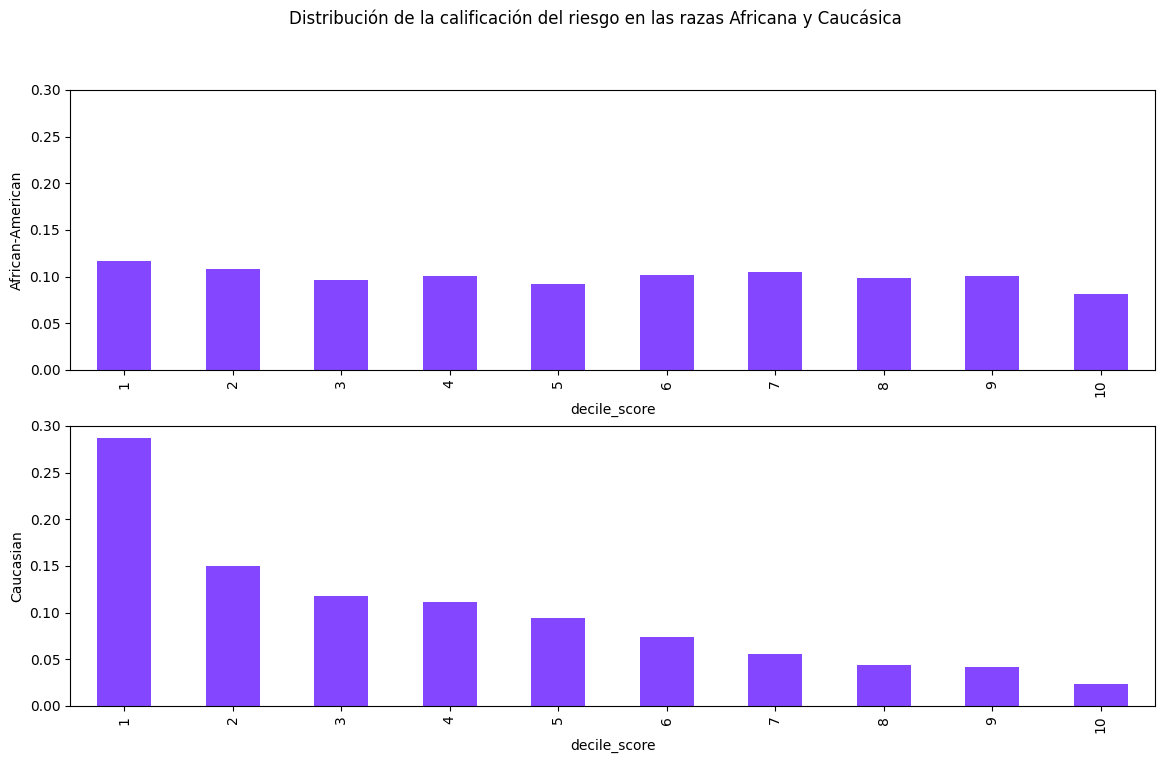

In [36]:
dfgb = df.groupby("race")
race_count = df.groupby("race")["name"].count()

fig, ax = plt.subplots(2, figsize=(14, 8))

for (i, race) in enumerate(["African-American", "Caucasian"]):
    (
        (dfgb
            .get_group(race)
            .groupby("decile_score")["name"].count() / race_count[race]
        )
        .plot(kind="bar", ax=ax[i], color="#8447FF")
    )
    ax[i].set_ylabel(race)
    ax[i].set_xlabel("decile_score")
   
    ax[i].set_ylim(0, 0.30)

fig.suptitle("Distribución de la calificación del riesgo en las razas Africana y Caucásica")
plt.show()

- La raza Africana tienen una tasa de delitos prácticamente idéntica para todas las calificaciones. Luego, dicha raza es impredecible.
- La raza Caucásica sigue una distribución logarítimica. Dandose la mayoría de los casos en las calificaciones más bajas.

Distribución de la calificación del riesgo por sexo

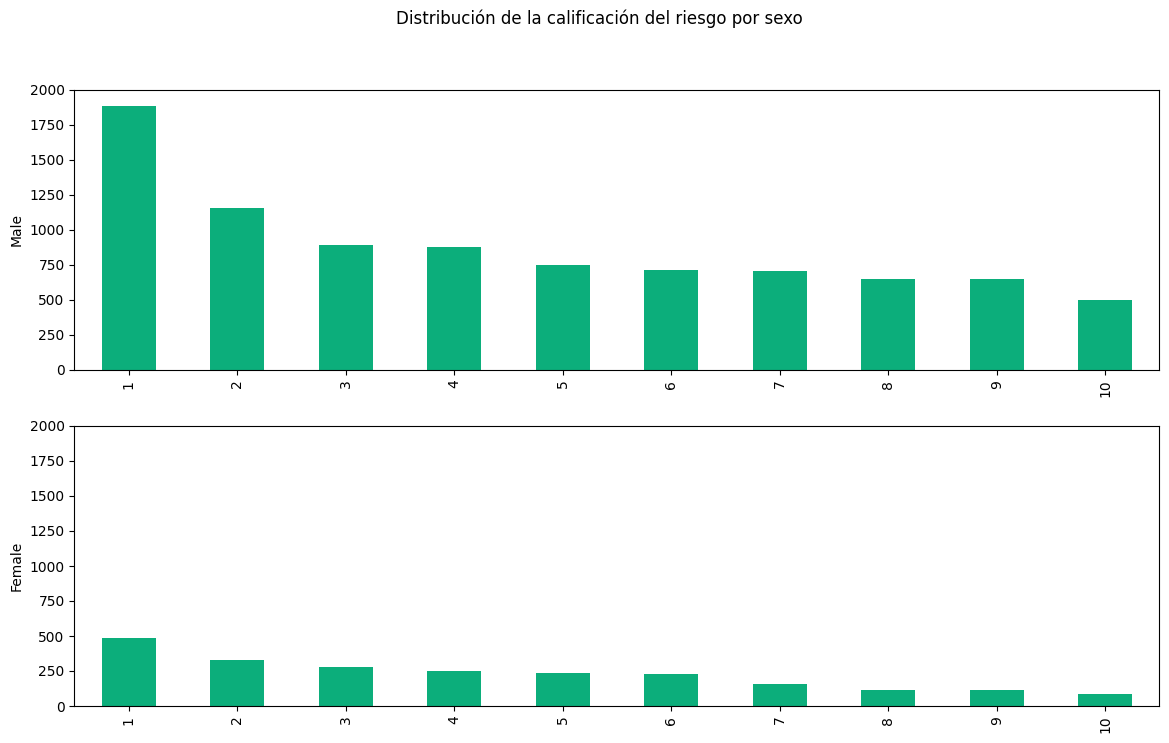

In [37]:
#Sex
dfgb = df.groupby("sex")
race_count = df.groupby("sex")["name"].count()

fig, ax = plt.subplots(2, figsize=(14, 8))

for (i, sex) in enumerate(["Male", "Female"]):
    (
        (dfgb
            .get_group(sex)
            .groupby("decile_score")["name"].count() 
         #/ race_count[race]
        )
        .plot(kind="bar", ax=ax[i], color="#0CAE7B")
    )
    ax[i].set_ylabel(sex)
    ax[i].set_xlabel("")
   
    ax[i].set_ylim(0, 2000)

fig.suptitle("Distribución de la calificación del riesgo por sexo")
plt.show()

- Ambas gráficas tienen una tendencia logarítmica. Luego, la mayor parte de delitos son leves.
- Observamos con claridad que los hombres son más propensos a cometer crímenes que las mujeres. Esto lo podemos ver en el órden de los valores del eje Y.

## 5.¿Para qué tipo de riesgos, el de delitos generales o el de delitos violentos, tiene el sistema más capacidad predictiva?

En el apartado 2, ya habíamos creado el modelo para delitos generales. De la misma manera generamos el modelo para delitos violentos.
En el apartado 3 habíamos evaluado el modelo. De la misma manera generamos la evaluación para delitos violentos y comparamos sus capacidades predictivas.

In [38]:
fit_v_decile_score = ols('v_decile_score ~ age + C(sex) + C(race) + C(is_recid) + C(is_violent_recid) + decile_score', data=df).fit() # hay que escribir C() si la variable es categórica

print(fit_v_decile_score.summary())

                            OLS Regression Results                            
Dep. Variable:         v_decile_score   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     2555.
Date:                Fri, 25 Nov 2022   Prob (F-statistic):               0.00
Time:                        13:12:42   Log-Likelihood:                -19151.
No. Observations:               11027   AIC:                         3.832e+04
Df Residuals:                   11016   BIC:                         3.840e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [40]:
prediction = fit_v_decile_score.predict(df) 

# generamos la tabla de contingencia, comparando los casos en los que se predice 
# un valor mayor que 7, con aquellos en los que realmente es mayor que 7
cm = pd.crosstab(prediction>=7, df.v_decile_score>=7, rownames=['prediction'], colnames=['real'])
cm

real,False,True
prediction,,
False,9219,1164
True,100,544


In [41]:
TN = cm[False][False]   
TP = cm[True][True]
FN = cm[True][False]
FP = cm[False][True]

print('Accuracy: ', (TN+TP)/(TN+TP+FN+FP))
print('PPV: ', TP / (TP + FP))
print('FPR: ', FP / (FP + TN))
print('FNR: ', FN / (FN + TP))
print()
# A continuación se muestra un resumen más detallado:

print(classification_report(df.v_decile_score>=7, prediction>=7))

Accuracy:  0.8853722680692845
PPV:  0.84472049689441
FPR:  0.010730765103551884
FNR:  0.6814988290398126

              precision    recall  f1-score   support

       False       0.89      0.99      0.94      9319
        True       0.84      0.32      0.46      1708

    accuracy                           0.89     11027
   macro avg       0.87      0.65      0.70     11027
weighted avg       0.88      0.89      0.86     11027



Como podemos observar, la predicción de la variable v_decile_score es levemente mejor con un 88.54% de precisión de acierto.
